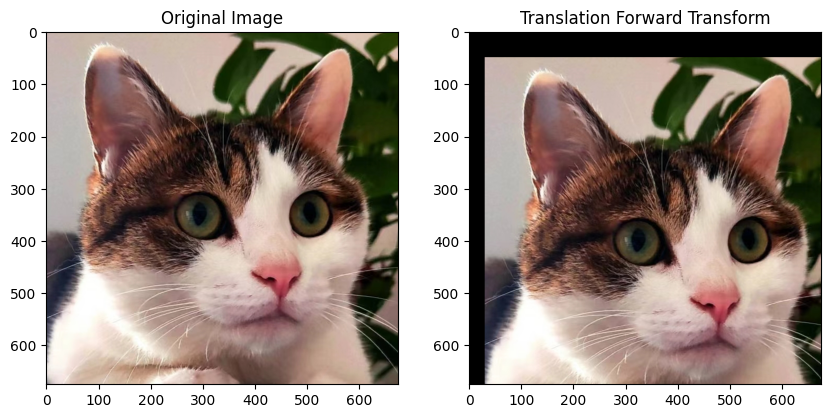

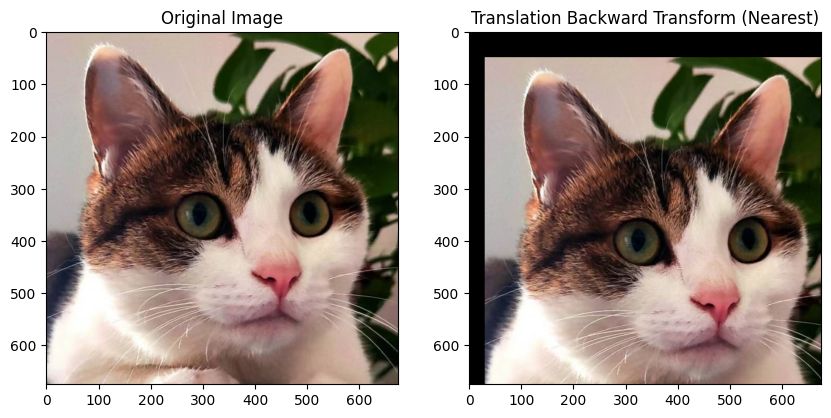

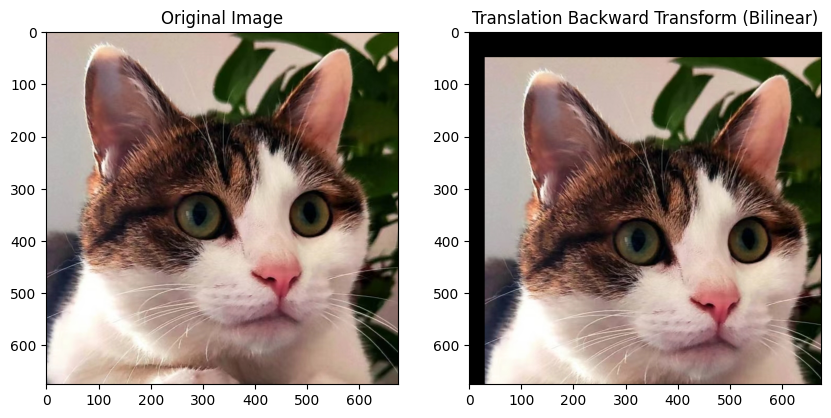

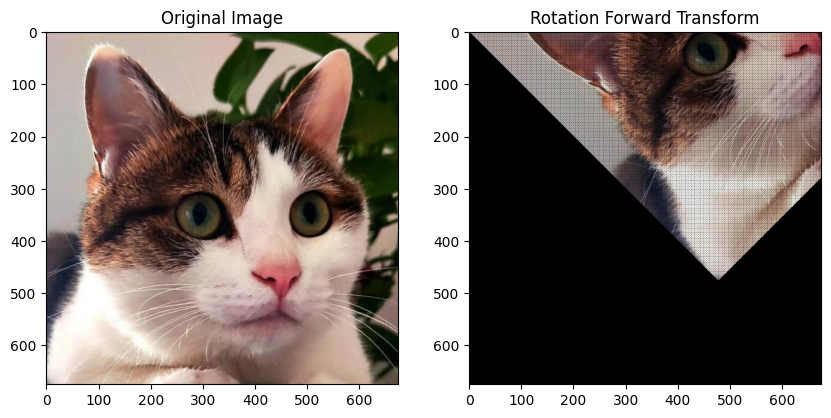

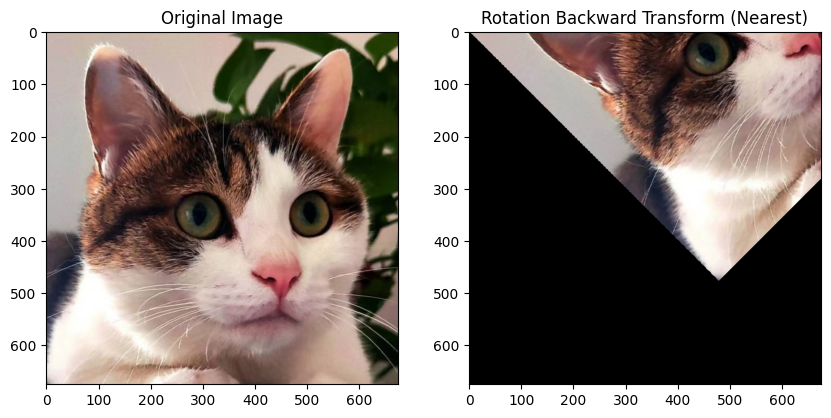

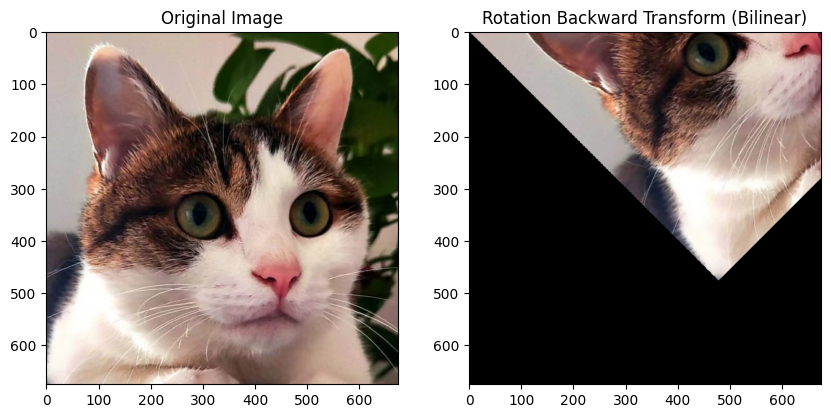

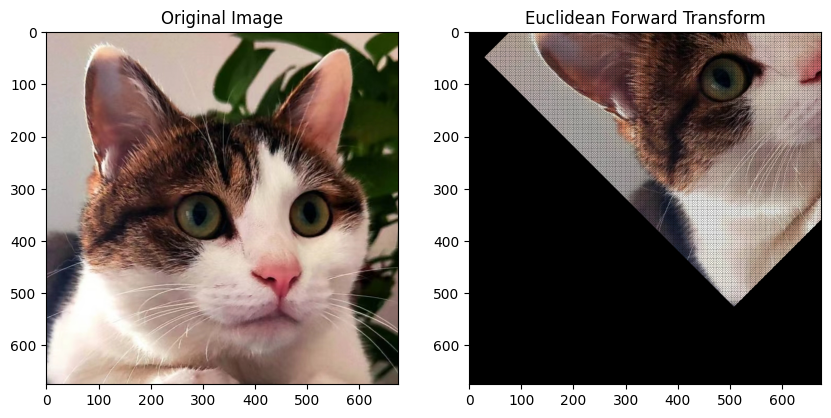

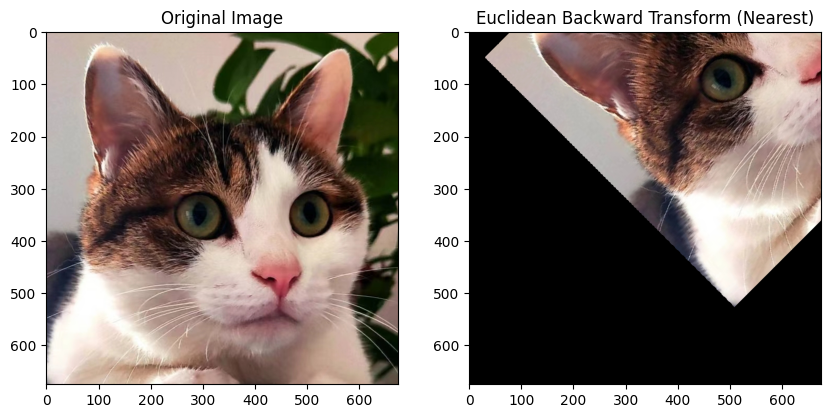

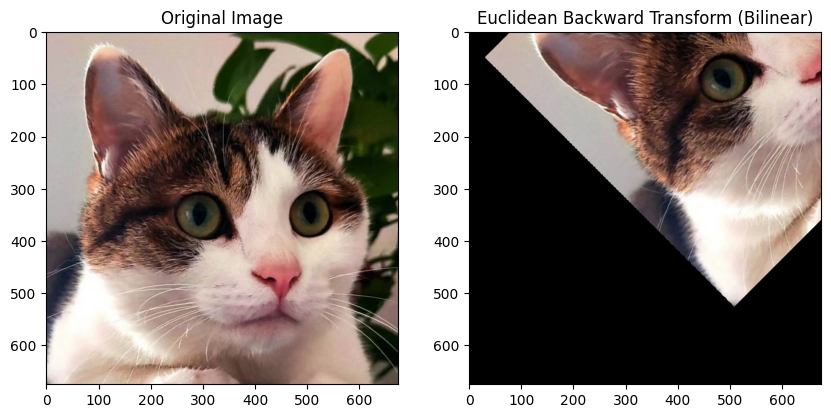

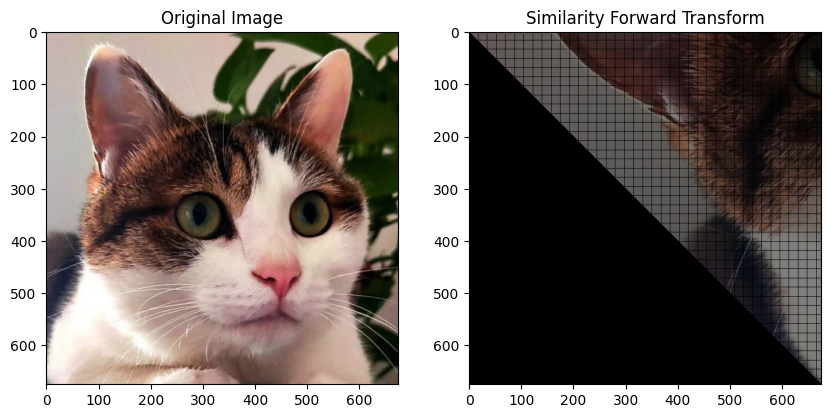

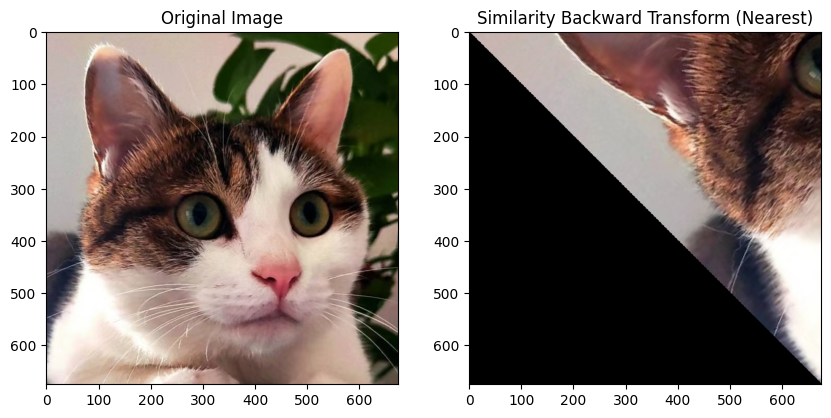

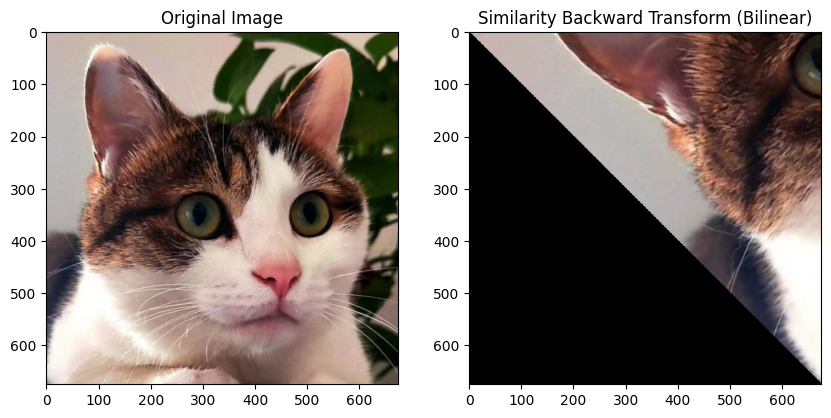

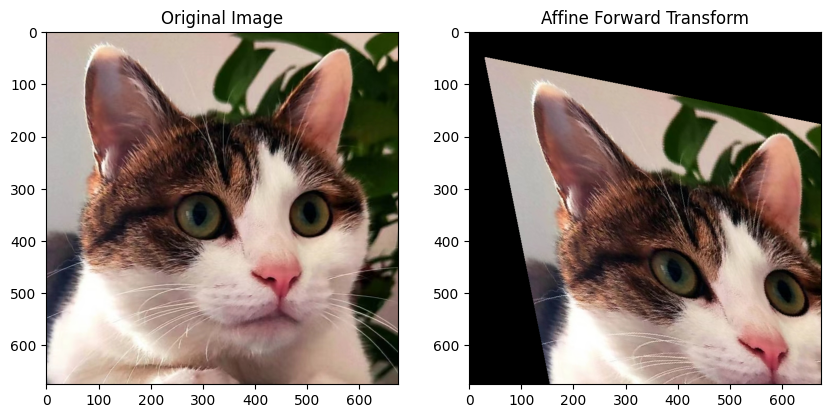

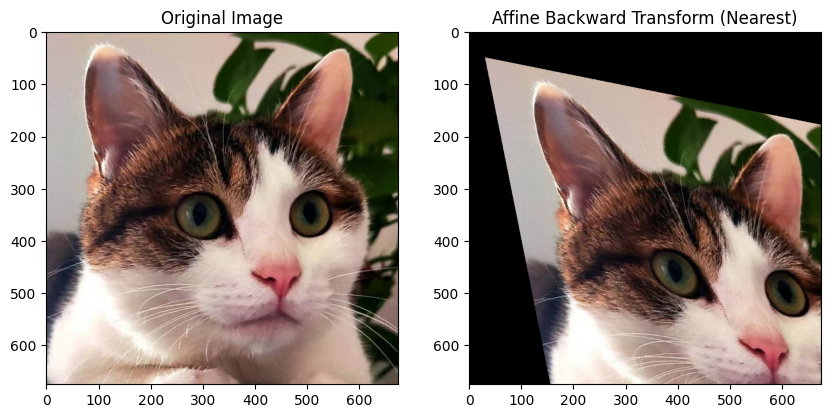

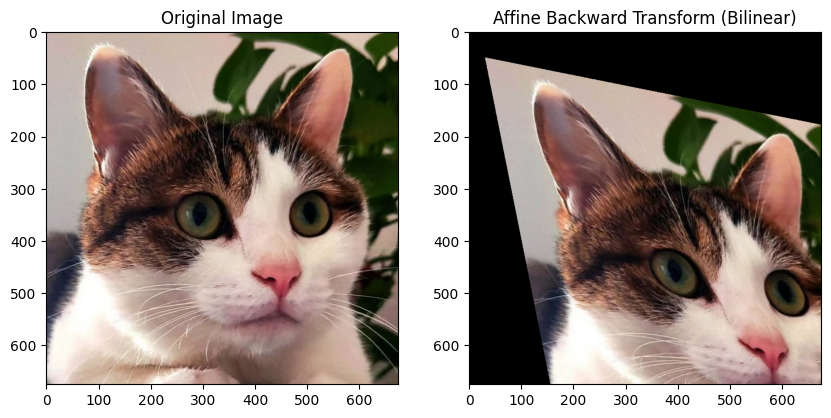

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def forward(img, T):
    h, w, c = img.shape
    transformed_img = np.zeros_like(img)
    
    for i in range(h):
        for j in range(w):
            pos = np.array([i, j, 1])
            new_pos = np.dot(T, pos)
            new_i, new_j = int(new_pos[0]), int(new_pos[1])

            if 0 <= new_i < h and 0 <= new_j < w:
                transformed_img[new_i, new_j] = img[i, j]

    return transformed_img

def backward(img, T, interpole='nearest'):
    h, w, c = img.shape
    transformed_img = np.zeros_like(img)
    T_inv = np.linalg.inv(T)

    for i in range(h):
        for j in range(w):
            pos = np.array([i, j, 1])
            orig_pos = np.dot(T_inv, pos)
            orig_i, orig_j = orig_pos[0], orig_pos[1]

            if 0 <= orig_i < h and 0 <= orig_j < w:
                if interpole == 'nearest':
                    orig_i, orig_j = int(orig_i), int(orig_j)
                    transformed_img[i, j] = img[orig_i, orig_j]
                elif interpole == 'bilinear':
                    x1, y1 = int(orig_i), int(orig_j)
                    x2, y2 = min(h-1, x1+1), min(w-1, y1+1)

                    for k in range(c):
                        R1 = (orig_i - x1) * img[x2, y1, k] + (x2 - orig_i) * img[x1, y1, k]
                        R2 = (orig_i - x1) * img[x2, y2, k] + (x2 - orig_i) * img[x1, y2, k]
                        transformed_img[i, j, k] = (orig_j - y1) * R2 + (y2 - orig_j) * R1

    return transformed_img

def plot_images(original, transformed, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()

img = cv2.imread('cat.jpg')

# 平移
T_translation = np.array([[1, 0, 50],
                            [0, 1, 30],
                            [0, 0, 1]])

# 旋转
angle = np.deg2rad(45)
T_rotation = np.array([[np.cos(angle), -np.sin(angle), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]])

# 欧氏
T_euclidean = np.dot(T_translation, T_rotation)

# 相似(缩放 + 旋转)
scaling_factor = 1.5
T_similarity = np.array([[scaling_factor * np.cos(angle), -scaling_factor * np.sin(angle), 0],
                            [scaling_factor * np.sin(angle), scaling_factor * np.cos(angle), 0],
                            [0, 0, 1]])

# 仿射
T_affine = np.array([[1, 0.2, 50],
                        [0.2, 1, 30],
                        [0, 0, 1]])

transformations = {
    "Translation": T_translation,
    "Rotation": T_rotation,
    "Euclidean": T_euclidean,
    "Similarity": T_similarity,
    "Affine": T_affine
}

for name, T in transformations.items():
    transformed_img_forward = forward(img, T)
    transformed_img_backward_nearest = backward(img, T, 'nearest')
    transformed_img_backward_bilinear = backward(img, T, 'bilinear')

    plot_images(img, transformed_img_forward, f'{name} Forward Transform')
    plot_images(img, transformed_img_backward_nearest, f'{name} Backward Transform (Nearest)')
    plot_images(img, transformed_img_backward_bilinear, f'{name} Backward Transform (Bilinear)')


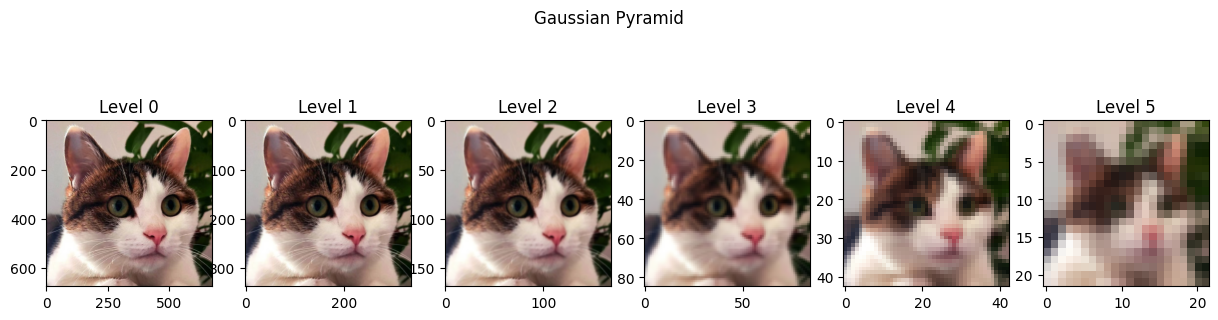

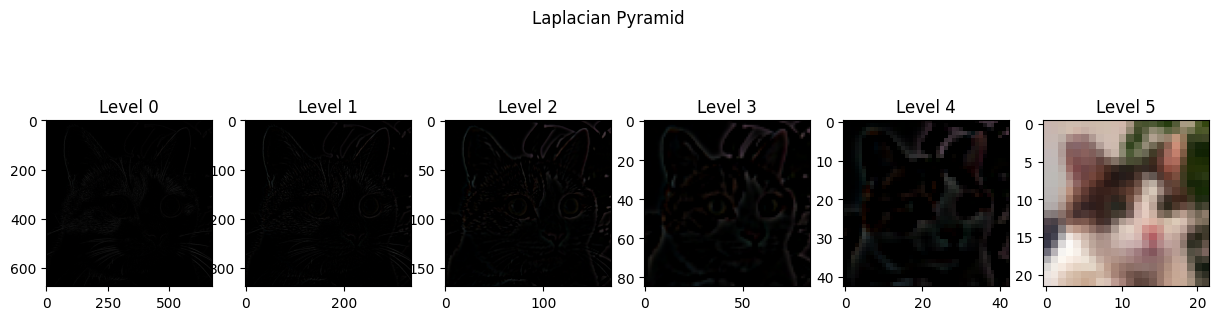

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_pyramid(pyramid, title):
    plt.figure(figsize=(15, 4))
    for i in range(len(pyramid)):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(cv2.cvtColor(pyramid[i], cv2.COLOR_BGR2RGB))
        plt.title(f'Level {i}')
    plt.suptitle(title)
    plt.savefig(title)
    plt.show()

def gaussian_pyramid(img, levels):
    pyramid = [img]
    for i in range(levels - 1):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    levels = len(gaussian_pyramid)
    for i in range(levels - 1):
        next_level_up = cv2.pyrUp(gaussian_pyramid[i+1], dstsize=(gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i], next_level_up)
        pyramid.append(laplacian)
    pyramid.append(gaussian_pyramid[-1])  # 最底层的高斯金字塔图像直接作为拉普拉斯金字塔的最后一层
    return pyramid

img = cv2.imread('cat.jpg')

# 构建高斯金字塔
levels = 6
gaussian_pyr = gaussian_pyramid(img, levels)
display_pyramid(gaussian_pyr, 'Gaussian Pyramid')

# 构建拉普拉斯金字塔
laplacian_pyr = laplacian_pyramid(gaussian_pyr)
display_pyramid(laplacian_pyr, 'Laplacian Pyramid')


In [11]:
img.shape

(675, 675, 3)

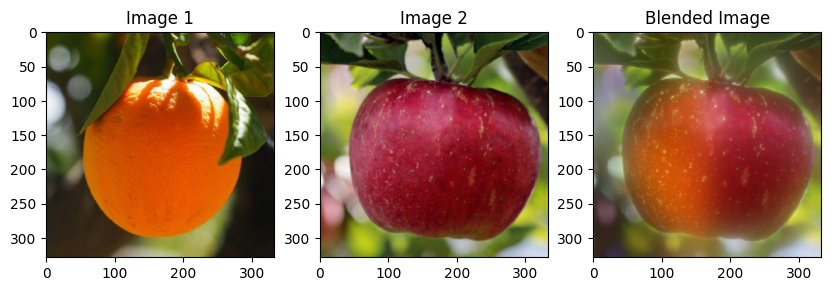

In [29]:
def build_gaussian_pyramid(img, levels):
    pyramid = [img]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        pyramid.append(img)
    return pyramid

def build_laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        next_level_up = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=(gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i], next_level_up)
        pyramid.append(laplacian)
    pyramid.append(gaussian_pyramid[-1]) 
    return pyramid

def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
    img = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        img = cv2.pyrUp(img, dstsize=(laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))
        img = cv2.add(img, laplacian_pyramid[i])
    return img

def blend_images(img1, img2, mask, levels):
    # 构建Gaussian
    gaussian_pyramid1 = build_gaussian_pyramid(img1, levels)
    gaussian_pyramid2 = build_gaussian_pyramid(img2, levels)
    gaussian_pyramid_mask = build_gaussian_pyramid(mask, levels)
    
    # 构建拉普拉斯
    laplacian_pyramid1 = build_laplacian_pyramid(gaussian_pyramid1)
    laplacian_pyramid2 = build_laplacian_pyramid(gaussian_pyramid2)
    laplacian_pyramid_mask = build_laplacian_pyramid(gaussian_pyramid_mask)
    
    # 融合
    blended_pyramid = []
    for l1, l2, lm in zip(laplacian_pyramid1, laplacian_pyramid2, laplacian_pyramid_mask):
        ls = l1 * lm + l2 * (1 - lm)
        blended_pyramid.append(ls)
    
    # 重建
    blended_image = reconstruct_from_laplacian_pyramid(blended_pyramid)
    return blended_image

img1 = cv2.imread('orange.jpg')
img2 = cv2.imread('apple.jpg')
img2 = cv2.resize(img2, img1.shape[:2][::-1])

rows, cols, _ = img1.shape
mask = np.zeros((rows, cols, 3), dtype=np.float32)
mask[:, :cols//2] = 1

levels = 6
blended_image = blend_images(img1, img2, mask, levels)
blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)
# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.savefig('Blended image.jpg')
plt.show()
